### Accelerating Python for Scientific Computing.

[Synthetic Use Case based on P. Haustin's Parallel Python Workshop. ](https://github.com/phaustin/parallel_python_course)


The idea of the below code is to show you how to accelerate your code with minimal effort. You can go all the way and write in C/C++, but then you'll spend more time writing code and less solving problems.

Let's say you're solving problem Y = f(X). It took you 10 hours to implement f in pure Python. It takes 10 days to execute f. F also has a lot of hyperparameters. It runs sequentially, but you have at least 4-8 cores in a modern machine. 

In this workshop I'll show you how to 
* accelerate sequential code
* use threads and processes to accelerate even more

And I'll show you how to do this with only minimal changes to your code. If you need to learn for a week how to write threaded optimized code, then it's not worth it if your code runs in a week. If you can add a single line in 5 minutes to decrease your runtime from a week to an hour, then you might be interested.

See ./config/install.md for full list of dependencies.
First, let's get all imports done.

In [78]:
import contexttimer
import cython
from numba import jit
import multiprocessing
import threading
from joblib import Parallel
import logging
import math
import time
import numpy as np
from scipy.spatial.distance import euclidean
from functools import reduce
%load_ext Cython
import warnings
warnings.simplefilter('ignore') # for sqrt overflow in synthetic case
import matplotlib.pyplot as plt
import vtk

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


## Overview
* Speeding up single threaded code
    * Cython
    * Numba
    * Vectorization
* Parallel Python -- Defeating the GIL
* Parallel IO & Large Datasets
* Visualization

# 0. Hello parallel world.
We define a simple N^4 function that does only computation, uses almost no memory. This example shows you how to get the code running, and what can be achieved. Later on we'll use a more realistic example.


### Why is Python in 2018 still not parallelizable? Enter the Global Interpreter Lock.
The GIL (Global Interpreter Lock) is the main obstacle for Python threading speedup. A single bottleneck that is triggered whenever Python Objects are referenced. High performance modules such as numpy (in C) don't use Python objects, so safely can ignore the GIL.
We will define 2 functions using Numba. Numba introduces decorators that will compile your function to C/C++ on the fly. It allows you to specify datatype (like in numpy) and release the GIL. Basically, you can write your own numpy-alike code, without the complexity of writing C!

#### Numba
Numba allows you to wrap your existing code in a decorator. It will type your code, compile it to C++ on the fly and optionally release the Global Interpreter Lock.

In [3]:
@jit('float64(int64)', nopython=True, nogil=True)
def wait_loop_nogil(n):
    out = 0
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=i**(1/2)
                    out=out**2.
    return out

@jit('float64(int64)', nopython=True, nogil=False)
def wait_loop_withgil(n):
    out = 0
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=i**(1/2)
                    out=out**2.
    return out

#### Python

In [4]:
def pure_python(n):
    out = 0
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=i**(1/2)
                    out=out**2.
    return out

#### Cython 

In [5]:
%%cython
def cython_loop_typed(long n):
    cdef double out
    cdef long m
    cdef long l
    cdef long j
    cdef long i
    out = 0
    for m in range(n):
        for l in range(m):
            for j in range(l):
                for i in range(j):
                    i=i+4
                    out=i**(1/2)
                    out=out**2.
    return out

#### Defining the benchmark function.

In [6]:
def benchmark_jitters(func, args, times):
    results = np.zeros((times, 3))
    for i in range(times):
        w, c, s = 0, 0, 0
        with  contexttimer.Timer(time.perf_counter) as wall:
            with contexttimer.Timer(time.process_time) as cpu:
                func(*args)
                w = wall.elapsed
                c = cpu.elapsed
                s = c/w
                results[i] = [w,c,s]
    return results

### How much does Just In Time Compilation help?

Let's first look at Pure Python vs Cython. Cython gains most of its speed from typing. Typical Python interpreters generate bytecode that can't make assumptions that compiled code can (type and size of a variable in memory can change between iterations in Python).

In [7]:
funcs = [ cython_loop_typed, pure_python]
times = 10
n = 200
N = len(funcs)
results = np.empty((N,times,3))
finals = np.empty((N,2))
for i,f in enumerate(funcs):
    print('Testing {}'.format(f.__name__))
    results[i] = benchmark_jitters(f, [n], times)
for i,r in enumerate(results):
    finals[i] = np.mean(r[:,0]), np.std(r[:,1])
M, m = [(-float('inf'), None), (float('inf'), None)]
    
for f,r in zip(funcs, finals):
    M = (r[0], f.__name__) if r[0] > M[0] else M
    m = (r[0], f.__name__) if r[0] < m[0] else m
    print('Mean time for {} is \t{:.2E} with std \t{:.2E}'.format(f.__name__, *r))

print('Worst is {} , best is {} with a speedup of {:.2E}'.format(M[1], m[1], M[0]/m[0]))


Testing cython_loop_typed
Testing pure_python
Mean time for cython_loop_typed is 	8.18E+00 with std 	5.86E-01
Mean time for pure_python is 	2.73E+01 with std 	9.50E-01
Worst is pure_python , best is cython_loop_typed with a speedup of 3.3338176178037973


### Cython is clearly faster, but the compiled code generated isn't that good.

Not as fast as expected, mainly because this code is computation bound (and not memory bound).

### JIT vs Cython.
How good is the generated code? Cython is not that easy to write (our example is trivial). Numba is more user friendly, and allows us to use objects, or if we don't, releases the GIL. 

Do you expect a speedup from single threaded code _releasing_ the GIL?

In [48]:
funcs = [wait_loop_withgil, wait_loop_nogil, cython_loop_typed]
times = 10
n = 200
N = len(funcs)
results = np.empty((N,times,3))
finals = np.empty((N,2))
for i,f in enumerate(funcs):
    print('Testing {}'.format(f.__name__))
    results[i] = benchmark_jitters(f, [n], times)

for i,r in enumerate(results):
    finals[i] = np.mean(r[:,0]), np.std(r[:,1])

M, m = [(-float('inf'), None), (float('inf'), None)]
    
for f,r in zip(funcs, finals):
    M = (r[0], f.__name__) if r[0] > M[0] else M
    m = (r[0], f.__name__) if r[0] < m[0] else m
    print('Mean time for {} is \t{:.2E} with std \t{:.2E}'.format(f.__name__, *r))

print('\nWorst is {} , best is {} with a speedup of {:.2E}'.format(M[1], m[1], M[0]/m[0]))

print('\nSpeedup of releasing the GIL is {:.2E}'.format(finals[0][0]/finals[1][0]))

Testing wait_loop_withgil
Testing wait_loop_nogil
Testing cython_loop_typed
Mean time for wait_loop_withgil is 	1.15E-02 with std 	4.36E-04
Mean time for wait_loop_nogil is 	1.12E-02 with std 	3.22E-04
Mean time for cython_loop_typed is 	8.45E+00 with std 	1.73E-01

Worst is cython_loop_typed , best is wait_loop_nogil with a speedup of 7.53E+02

Speedup of releasing the GIL is 1.02E+00


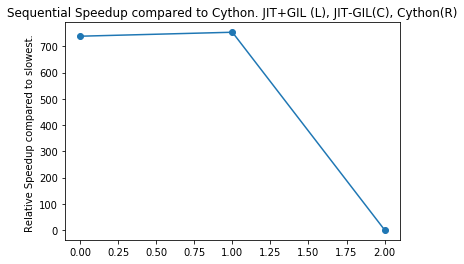

In [50]:
best=M[0]
x = [i for i in range(len(funcs))]
means, sd = best/finals[:,0], finals[:,1]
fig, ax0= plt.subplots(nrows=1, sharex=True)
ax0.errorbar(x, means, yerr=sd, fmt='-o')
ax0.set_title('Sequential Speedup compared to Cython. JIT+GIL (L), JIT-GIL(C), Cython(R)')
ax0.set_ylabel('Relative Speedup compared to slowest. ')
# ax0.set_yscale('log')
plt.show()

### JIT is _significantly_ faster than Cython for our example. Releasing the GIL adds even more speed.
The reason is the generated code. Numba uses LLVM which invokes Clang with very aggresive optimizations. The quality of C++ code makes all the difference here.

## Threads and processes in Python made easy with joblib.

The threshold of writing process managing code is quite high in Python (multiprocess module, MPI), high enough that it's not worth investing time in it. Joblib makes the threshold significantly lower so you can enjoy a parallel speedup. 

### A Note about Time

We're using contexttimer, which allows us to see the actual time (wall clock) and cpu time used. The distinction is _important_.
* Wall time: Physical real world time
* CPU time: time where the CPU is executing your code (user CPU time) or doing syscalls (system CPU).

Simply timing a function is not going to tell you much about speedup or stalls. When threads hit the GIL, they will stalls so even with 20 cores/threads your CPU time will not be more than wall time. 

* __Wall < CPU__ : Parallel Speedup
* __Wall = CPU__ : Stalled on locks
* __Wall > CPU__ : Stalled on IO/Syscalls,Scheduler

### Processes and Threads
A process has its own memory, a thread (can) share(s) memory. If you can't afford copying data (which you need to do with processes), don't use processes. A process is heavyweight, a thread less so. Threads, however, don't scale that well, you have limited CPUs. Don't use more threads than you have cores. Don't expect 'hyperthreading' to give you a linear speedup.

In [40]:
njobs, nprocs, nloops = 32, 16, 1000

#### Let's define a benchmark function

In [45]:
def benchmark(func, jobs, processes, posargs=[], kwargs={}, useprocs=False):
    calc_jobs=[(func,posargs,kwargs) for i in range(jobs)]    
    w, c, s = 0, 0, 0
    with  contexttimer.Timer(time.perf_counter) as wall:
        with contexttimer.Timer(time.process_time) as cpu:
            with Parallel(n_jobs=processes,backend='threading' if not useprocs else 'multiprocessing') as parallel:
                parallel(calc_jobs)
                w = wall.elapsed
                c = cpu.elapsed
                s = c/w
            print(f'Wall time {wall.elapsed} and Cpu time {cpu.elapsed}')
    print(f'Effective Parallel Speedup (1 is None) = {cpu.elapsed/wall.elapsed}')
    return w,c,s

#### Threading With the GIL

In [46]:
print('Threading speedup with {} jobs spread over {} threads'.format(njobs, nprocs))
wall, cpu, speedup = benchmark(wait_loop_withgil, njobs, nprocs, [nloops], {})
print('Speedup ratio (1 = Linear) {}'.format(speedup/nprocs))

Threading speedup with 32 jobs spread over 16 threads
Wall time 15.853111556731164 and Cpu time 15.458750341999917
Effective Parallel Speedup (1 is None) = 0.9668269277923749
Speedup ratio (1 = Linear) 0.061146780829325405


#### Without GIL

In [47]:
print('Parallel speedup with {} jobs spread over {} threads'.format(njobs, nprocs))
wall, cpu, speedup = benchmark(wait_loop_nogil, njobs, nprocs, [nloops], {})
print('Speedup ratio (1 = Linear) {}'.format(speedup/nprocs))

Parallel speedup with 32 jobs spread over 16 threads
Wall time 1.2766712736338377 and Cpu time 16.184895294000057
Effective Parallel Speedup (1 is None) = 12.676078460840811
Speedup ratio (1 = Linear) 0.8317403540912072


With the GIL there is simply __no__ way to accelerate code (unless your code does IO, calls numpy or C libs.)
Without the GIL we have a __linear__ speedup.

#### What about processes?

In [48]:
print('Parallel speedup with {} jobs spread over {} processes'.format(njobs, nprocs))
wall, cpu, speedup = benchmark(wait_loop_nogil, njobs, nprocs, [nloops], {}, useprocs=True)
print('Speedup ratio (1 = Linear) {}'.format(speedup/nprocs))

Parallel speedup with 32 jobs spread over 16 processes
Wall time 6.1091247741132975 and Cpu time 0.2125228639999932
Effective Parallel Speedup (1 is None) = 0.03507276574392902
Speedup ratio (1 = Linear) 0.002182622035330477


Processes are a _poor_ choice when the compute time is short and require a copy of data. A good use case for processes is grid search, long running expensive code with almost no copying.

# 1. A more realistic Use Case: Pairwise Matching of Clusters
2 3D point clouds (R, G) each clustered into k, l clusters. Align the 'nearest' clusters.
We'll use Chamfer distance, and see if we can accelerate using vectorization, threading, JIT.

A note on distance functions and speed: 
* You can use Ball/KD Trees to accelerate this with NlogN
* You can use dot product (sklearn pairwise) but it won't be symmetric

### Let's solve the problem itself first.
* Define Chamfer distance
    * Using pure Python
    * Using map-reduce
    * JIT'ed
* Define pairing function
    * Using map-reduce

In [9]:
def gen_clusters(n, m, seed=0):
    # Generate N clusters of up to m 3D points per cluster with random Gaussian distribution (x/y/z independent)
    np.random.seed(seed)
    meanrange = [1,10]
    sigmarange = [1,3]
    # Preallocation will fail since we don't know size of each cluster (1 < m)
    clusters = []
    for m in np.random.randint(1, m, n):
        means, sigmas = np.random.randint(*meanrange, 3), np.random.randint(*sigmarange, 3)
        cluster = np.random.normal(loc=means, scale=sigmas, size=(m, 3))
        clusters.append(cluster)
    return clusters
    

def chamfer_pure(left, right):
    '''
    Pure Python code to compute Chamfer distance between two unequal sized clusters
    '''
    lr = 0
    NL, NR = len(left), len(right)
    for li in range(NL):
        l = left[li]     # Numba doesn't implement type inference when iterating over K-D arrays
        m = float('inf')
        for ri in range(NR):
            r = right[ri]
            dlr = np.sqrt(np.dot(l, r))
            m = min(m, dlr)
        lr += m
    rl = 0
    for ri in range(NR):
        r = right[ri]
        m = float('inf')
        for li in range(NL):
            l = left[li]
            dlr = np.sqrt(np.dot(l, r))
            m = min(m, dlr)
        rl += m
    return max(lr/NL, rl/NR)

#### Going deeper with Numba
Note how we now have not a simple int, but 2 2 dimensional arrays as input. Also, we want to see if builtin parallellism can be used.

Our question is, how much work does it take to write chamfer_pure in numba?

In [18]:
@jit('float64(float64[:,:], float64[:,:])', nopython=True, nogil=True)  # cache=True can't be used with parallel
def chamfer_JIT_bells_whistles(left, right):
    '''
    JIT'ed version, but with a subtle mistake crippling performance. 
    I will buy the (first) person who finds the bug a (Belgian) beer.
    '''
    lr = 0
    NL, NR = len(left), len(right)
    for li in range(NL):
        l = left[li]     # Numba doesn't implement type inference when iterating over K-D arrays
        m = np.inf
        for ri in range(NR):
            r = right[ri]
            dlr = np.sqrt(np.dot(l, r))    
            m = min(m, dlr)
        lr += m
    rl = 0
    for ri in range(NR):
        r = right[ri]
        m = np.inf
        for li in range(NL):
            l = left[li]     # Numba doesn't implement type inference when iterating over K-D arrays
            dlr = np.sqrt(np.dot(l, r))
            m = min(m, dlr)
        rl += m
    return max(lr/len(left), rl/len(right))

@jit(nopython=True, nogil=True)
def chamfer_JIT(left, right):
    '''
    JIT'ed version
    '''
    lr = 0
    NL, NR = len(left), len(right)
    for li in range(NL):
        l = left[li]     # Numba doesn't implement type inference when iterating over K-D arrays
        m = np.inf
        for ri in range(NR):
            r = right[ri]
            dlr = np.sqrt(np.dot(l, r))   
            m = min(m, dlr)
        lr += m
    rl = 0
    for ri in range(NR):
        r = right[ri]
        m = np.inf
        for li in range(NL):
            l = left[li]     # Numba doesn't implement type inference when iterating over K-D arrays
            dlr = np.sqrt(np.dot(l, r))
            m = min(m, dlr)
        rl += m
    return max(lr/len(left), rl/len(right))



### @jit
@jit(' returntype ( argument types) ', nopython=True/False, nogil=True/False, parallel=True/False, cache=True/False

* returntype: float64, int64, type[:] (single array)
* argument types: same as returntypes
* nopython: don't work with objects (classes) --> everything in Python is an Object, so a void*, and so invokes indirection, pointer chasing, runtime typing.
* nogil : Release the Global Interpreter Lock (only if you're not using objects
* parallel : use openmp to parallelize your code
* cache : store the compiled code to a file (if you run your code 10 times, instead of running a function 10 times)

## So what did we need to change?
Numba 0.4 does not support for x in array if array is 2 or higher dimensional. So we need to change to code to use indices.
The rest of the code is the same.

Numba will try to JIT library code, but if it fails be prepared for some deep diving into typing.

## Adding Functional Programming to the mix
The above code is long, for something we can intuitively express in one sentence.

__For each clusterset, find the index of the nearest cluster in the other set.__

Using functional programming we can get a lot closer to our intent.

In [10]:
def chamfer_mapreduce(left, right):
    '''
    Python's Map Reduce style of computing Chamfer
    '''
    L = sum(map(lambda l: min(map(lambda r: np.sqrt(np.dot(l,r)), right)), left))/len(left)
    R = sum(map(lambda r: min(map(lambda l: np.sqrt(np.dot(l,r)), left)), right))/len(right)
    return max(L, R)

    
def pairs_mapreduce(left, rights, chamfer_func):
    '''
    Find index of right cluster in rights nearest to left using chamfer_func 
    '''
    return min(map(lambda R: (chamfer_func(left, R[1]), R[0]), enumerate(rights)))[1]


def solve(L, R, chamfer_func, pairfunc):
    return [pairfunc(l,R, chamfer_func) for l in L], [pairfunc(r,L,chamfer_func) for r in R]
            
    

### Understanding Map-Reduce (and when to use it)

```Python
map( function, iterable) -> iterable
```
Map returns a new iterable (collection, list, array, dict, ...) where each element is replaced by the result of function(element)

```Python
map( lambda x : x**2, [1,2,3]) == [1,4,9]
```

A lambda function is an anonymous function typically used in functional programming describing in a single expression the operation to be performed.

##### Why should you care?
Map, Reduce, Filter, Itertools, Lambda are succinct expressions what you want to do, and they don't generate intermediate copies. Use them for streams, large data or generated data where in memory storing is too expensive.
Unless you hit memory limits they will not be faster, but they __will__ save memory.

Map does not 'create' a new list, it creates a generator object.

##### Sum of first 1e5 squares. The maximum list size is __1__
```Python
sum(map(lambda x : x**2, (i for i in range(100000))))
```
Note (i for i in range(N))

This is a generator object, not a list. If we use [i for i in range(N)] we have a list of 1e5 numbers.
Technically these are generator comprehension and list comprehension.

__Note__ : A generator is exhausted after usage. 

(i for i in range(N)) is equivalent to writing:
```Python
def mygenerator(N):
    n = 1
    yield n
    n += 1
```
[ i for in range(N))] is equivalent to writing:
```Python
def mylistcomprehension(N):
    l = []
    for i in range(N)
        l.append(i)
    return l
```


#### Decrypting functional oneliners.
Great, so how do we read:
```Python
return min(map(lambda R: (chamfer_func(left, R[1]), R[0]), enumerate(rights)))[1]
```

The lambda accepts R, a tuple of an index and a cluster (R[0] and R[1]).
It computes the chamfer distances between 'left' and each cluster in rights. It then finds the minimum distance. 

So:

* map(...) --> A: ((distance, index), (distance, index), ...)

* min(((distance, index), (distance, index), ...)) --> (mindist, corresponding cluster index)

* Finally [1] selects the index.

# Analysis


Let's make some data. 

While we do so, look at how you can use list, dictionary and * to neatly express what we want.

In [14]:
params = {'L':{'cluster_count':50, 'max_size':35, 'seed':1},  'R':{'cluster_count':30, 'max_size':23, 'seed':2}}

L, R = [gen_clusters(*[value for key, value in p.items()]) for _, p in params.items()]

points = sum(sum(len(q) for q in Q) for Q in [L,R]) # double nested for loop saved.

print('Total of {} points in L+R'.format(points))

Total of 1090 points in L+R


## Visualizing the Data with VTK/Paraview.

In [108]:
class VtuWriter(object):
    def __init__(self, filename, points, values):
        '''
        Appends .vtu to filename
        '''
        self._points= vtk.vtkPoints()
        self._grid = vtk.vtkUnstructuredGrid()
        self._values = vtk.vtkDoubleArray()
        self._values.SetName('point_values_array')
        self._grid.SetPoints(self._points)
        self._grid.GetPointData().SetScalars(self._values)
        self._loadPoints(points, values)
        self._write("{}.vtu".format(filename))

    def _loadPoints(self, points, values):
        poly = vtk.vtkPolyVertex()
        poly.GetPointIds().SetNumberOfIds(points.shape[0])
        for i, (point, value) in enumerate(zip(points, values)):
            poly.GetPointIds().SetId(i, self._points.InsertNextPoint(point))
            self._values.InsertNextValue(value) # fix arbitrary data
        self._grid.InsertNextCell(poly.GetCellType(), poly.GetPointIds())

    def _write(self, filename):
        writer = vtk.vtkXMLUnstructuredGridWriter()
        writer.SetFileName(filename)
        writer.SetInputData(self._grid)
        writer.Write()

        
def concatenateArrays(points):
    rows = [p.shape[0] for p in points]
    result = np.empty((sum(rows), points[0].shape[1]))
    values = np.zeros((sum(rows), 1))
    rownr = 0
    for index,p in enumerate(points):
        result[rownr:rownr+rows[index]] = p
        rownr += rows[index]
        values[rownr:rownr+rows[index]] = index
    return result, values
    
def writeClustersMerged(C):
    for i,c in enumerate(C):
        merged = concatenateArrays(c)
        print('Writing {}'.format(len(merged[0])))
        VtuWriter('cluster_{}'.format(i), *merged)

In [109]:
writeClustersMerged([L,R])

Writing 6449
Writing 4116


### Visualize with Paraview.
* Open Paraview
* Load State
* Select ./state/

![Clusters visualized in Paraview](./img/data_set.png "Title")


### Pure vs Functional

In [16]:
# Let's define some shorthands
def solve_pure(L, R):
    return solve(L, R, chamfer_pure, pairs_mapreduce)

def solve_mapreduce(L,R):
    return solve(L, R, chamfer_mapreduce, pairs_mapreduce)

funcs = [solve_pure, solve_mapreduce]
times = 2
N = len(funcs)
results, finals = np.empty((N,times,3)), np.empty((N,2))

for i,f in enumerate(funcs):
    print('Testing {}'.format(f.__name__))
    results[i] = benchmark_jitters(f, [L,R], times)

for i,r in enumerate(results):
    finals[i] = np.mean(r[:,0]), np.std(r[:,1])

M, m = [(-float('inf'), None), (float('inf'), None)]
    
for f,r in zip(funcs, finals):
    M = (r[0], f.__name__) if r[0] > M[0] else M
    m = (r[0], f.__name__) if r[0] < m[0] else m
    print('Mean time for {} is \t{:.2E} with std \t{:.2E}'.format(f.__name__, *r))

print('\nWorst is {} , best is {} with a speedup of {:.2E}'.format(M[1], m[1], M[0]/m[0]))

Testing solve_pure
Testing solve_mapreduce
Mean time for solve_pure is 	9.01E+00 with std 	6.07E-02
Mean time for solve_mapreduce is 	8.27E+00 with std 	1.15E-01

Worst is solve_pure , best is solve_mapreduce with a speedup of 1.09E+00


#### Map Reduce doesn't improve that much in speed (small data sets, computation dominated). 

### Pure vs JIT

In [23]:
def solve_pure(L, R):
    return solve(L, R, chamfer_pure, pairs_mapreduce)

def solve_mapreduce(L,R):
    return solve(L, R, chamfer_mapreduce, pairs_mapreduce)

def solve_jit(L, R):
    return solve(L, R, chamfer_JIT, pairs_mapreduce)
    
def solve_jitplus(L, R):
    return solve(L, R, chamfer_JIT_bells_whistles, pairs_mapreduce)

funcs = [solve_pure, solve_mapreduce, solve_jit]
times = 10
N = len(funcs)
results = np.empty((N,times,3))
finals = np.empty((N,2))
for i,f in enumerate(funcs):
    print('Testing {}'.format(f.__name__))
    results[i] = benchmark_jitters(f, [L,R], times)

for i,r in enumerate(results):
    finals[i] = np.mean(r[:,0]), np.std(r[:,1])

M, m = [(-float('inf'), None), (float('inf'), None)]
    
for f,r in zip(funcs, finals):
    M = (r[0], f.__name__) if r[0] > M[0] else M
    m = (r[0], f.__name__) if r[0] < m[0] else m
    print('Mean time for {} is \t{:.2E} with std \t{:.2E}'.format(f.__name__, *r))

best = m[0]
print('\nWorst is {} , best is {} with a speedup of {:.2E}'.format(M[1], m[1], M[0]/m[0]))

Testing solve_pure
Testing solve_mapreduce
Testing solve_jit
Mean time for solve_pure is 	8.50E+00 with std 	2.38E-01
Mean time for solve_mapreduce is 	7.77E+00 with std 	2.65E-01
Mean time for solve_jit is 	7.53E-02 with std 	1.63E-02

Worst is solve_pure , best is solve_jit with a speedup of 1.13E+02


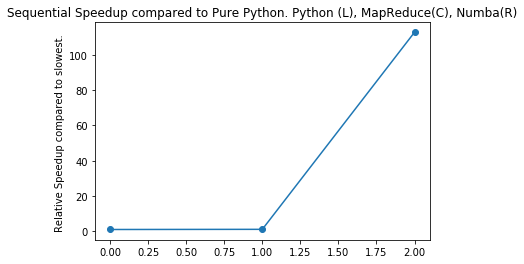

In [47]:
best=M[0]
x = [i for i in range(len(funcs))]
means, sd = best/finals[:,0], finals[:,1]
fig, ax0= plt.subplots(nrows=1, sharex=True)
ax0.errorbar(x, means, yerr=sd, fmt='-o')
ax0.set_title('Sequential Speedup compared to Pure Python. Python (L), MapReduce(C), Numba(R)')
ax0.set_ylabel('Relative Speedup compared to slowest. ')
# ax0.set_yscale('log')
plt.show()

The explicitly typed JIT code is slower due to a mistake in the type declaration.

### Parallell
So now we have an order of magnitude speedup. This was sequential only. We're already using numpy. 
Let's go parallel.

L = [l1, l2, ..., ln]
R = [r1, r2, ..., rn]

So let's split the work in two (L-R and R to L)
Then we split the work in l1-R, l2-R, ....

In [58]:
# Define shorthand
def psolve(l, R):
    pairs_mapreduce(l, R, chamfer_JIT)

def solve(L, R, chamfer_func, pairfunc):
    return [pairfunc(l,R, chamfer_func) for l in L], [pairfunc(r,L,chamfer_func) for r in R]
            

def benchmark_solver(L, R, processes, useprocs=False):
    calc_jobs=[(psolve, [l, R],{}) for l in L] + [(psolve, [r, L],{}) for r in R]
    w, c, s = 0, 0, 0
    with  contexttimer.Timer(time.perf_counter) as wall:
        with contexttimer.Timer(time.process_time) as cpu:
            with Parallel(n_jobs=processes,backend='threading' if not useprocs else 'multiprocessing') as parallel:
                r=parallel(calc_jobs)
                w = wall.elapsed
                c = cpu.elapsed
                s = c/w
    return w,c,s

In [164]:
params = {'L':{'cluster_count':400, 'max_size':200, 'seed':1},  'R':{'cluster_count':200, 'max_size':450, 'seed':2}}

L, R = [gen_clusters(*[value for key, value in p.items()]) for _, p in params.items()]

points = sum(sum(len(q) for q in Q) for Q in [L,R]) # double nested for loop saved.

print('Total of {} points in L+R'.format(points))

Total of 83219 points in L+R


## Weak Scaling behaviour of Parallel Python
#### What happens if we have the same amount of work but throw more threads at it?

In [161]:
procs = [2,4,8,16,32]
times = 10
njobs = len(L) + len(R)
results = np.zeros((len(procs), times, 4))
finals = np.zeros((len(procs), 2))
for ni,nprocs in enumerate(procs):
    for t in range(times):
        wall, cpu, speedup = benchmark_solver(L, R, nprocs, False)
        ratio = speedup/nprocs
        results[ni][t] = wall, cpu, speedup, ratio
    finals[ni] = np.mean(results[ni][:,2]), np.std(results[ni][:,2])
            
for p,(m,s) in zip(procs, finals):
    print('Using {} threads achieves mean speedup {:.2E} +- {:.2E}'.format(p, m, s))
    print('Using {} threads achieves mean relative speedup {:.2E} +- {:.2E}'.format(p, m/p, s))

Wall time 165.43012145068496 and Cpu time 321.4172645919998
Effective Parallel Speedup (1 is None) = 1.939507388952666
Wall time 167.59992555342615 and Cpu time 324.21549043100003
Effective Parallel Speedup (1 is None) = 1.9322688819263387
Wall time 174.86549894604832 and Cpu time 324.05219635400044
Effective Parallel Speedup (1 is None) = 1.8504412337462075
Wall time 188.68512505758554 and Cpu time 321.3511342890006
Effective Parallel Speedup (1 is None) = 1.7016074161897083
Wall time 182.22527581453323 and Cpu time 325.06370527800027
Effective Parallel Speedup (1 is None) = 1.782608818620311
Wall time 180.87644483707845 and Cpu time 321.3229615449991
Effective Parallel Speedup (1 is None) = 1.7746769066244532
Wall time 183.85728101525456 and Cpu time 321.6588034390006
Effective Parallel Speedup (1 is None) = 1.7485367182477713
Wall time 184.30601975601166 and Cpu time 320.9943826310009
Effective Parallel Speedup (1 is None) = 1.7404760306804057
Wall time 198.5391414044425 and Cpu tim

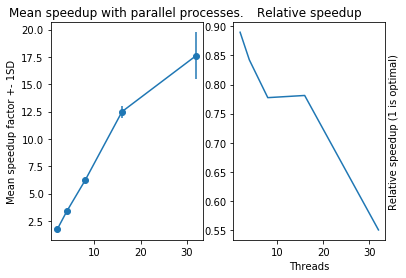

In [55]:
x = [2,4,8,16,32]
means, sd = [1.78, 3.37, 6.22, 12.5, 17.6], [1.01e-01, 1.18e-01, 1.166e-01, 5.58e-01, 2.16] 
rel = [m/x for (m,x) in zip(means, x)]
fig, (ax0, ax1)= plt.subplots(ncols=2, sharex=True)
ax0.errorbar(x, means, yerr=sd, fmt='-o')
ax0.set_title('Mean speedup with parallel processes.')
ax0.set_ylabel('Mean speedup factor +- 1SD')
ax1.plot(x, rel)
ax1.set_xlabel('Threads')
ax1.set_ylabel('Relative speedup (1 is optimal)')
ax1.yaxis.set_label_position("right")
ax1.set_title('Relative speedup')
plt.show()

## Strong Scaling: Same number of threads, but increase the load.

In [72]:
ccounts = [10, 20, 40, 80, 160]
nprocs = 4
times = 10
njobs = len(L) + len(R)
results = np.zeros((len(ccounts), times, 4))
finals = np.zeros((len(ccounts), 2))
points = []
for ni,c in enumerate(ccounts):
    print('Generating data with {}'.format(c))
    params = {'L':{'cluster_count':c+5, 'max_size':80, 'seed':1},  'R':{'cluster_count':c-5, 'max_size':50, 'seed':2}}
    L, R = [gen_clusters(*[value for key, value in p.items()]) for _, p in params.items()]
    points.append( sum(sum(len(q) for q in Q) for Q in [L,R]) )
    
    for t in range(times):
        wall, cpu, speedup = benchmark_solver(L, R, nprocs, False)
        ratio = speedup/nprocs
        results[ni][t] = wall, cpu, speedup, ratio
    finals[ni] = np.mean(results[ni][:,2]), np.std(results[ni][:,2])
    
for p,(m,s),pts in zip(ccounts, finals, points):
    print('Using {} jobs achieves mean speedup {:.2E} +- {:.2E}'.format(pts, m, s))

Generating data with 10
Generating data with 20
Generating data with 40
Generating data with 80
Generating data with 160
Using 689 jobs achieves mean speedup 2.43E+00 +- 3.35E-01
Using 1219 jobs achieves mean speedup 3.11E+00 +- 3.06E-01
Using 2558 jobs achieves mean speedup 3.64E+00 +- 2.38E-01
Using 5107 jobs achieves mean speedup 3.84E+00 +- 6.84E-02
Using 10565 jobs achieves mean speedup 3.69E+00 +- 1.51E-01


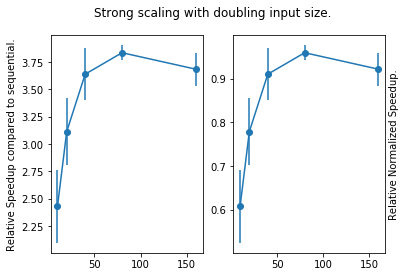

In [76]:
x = ccounts
means, sd = finals[:,0], finals[:,1]
fig, (ax0,ax1)= plt.subplots(ncols=2, sharex=True)
ax0.errorbar(x, means, yerr=sd, fmt='-o')
plt.suptitle('Strong scaling with doubling input size.')
ax0.set_ylabel('Relative Speedup compared to sequential.')
ax1.errorbar(x, means/nprocs, yerr=sd/nprocs, fmt='-o')
ax1.set_ylabel('Relative Normalized Speedup.')
ax1.yaxis.set_label_position("right")
plt.show()

## Conclusion

* Sequental Speedup: __x10-100__
* Parallel Speedup: __.5-1 * per thread__

## Tips
* Don't use more threads than you have cores (and with hyperthreading you will rarely get linear speedup)
